# Coordinate Ascent Variational Inference on Probabilistic Count Matrix Factorization

Note: when N != P, there is an identifiability issue if alpha_k2 goes to zero or beta_k2 goes to infinity or vice-versa.

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import utils, inference

from ZIFA import ZIFA

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.stats import gamma

plt.style.use('ggplot')

## Data generation

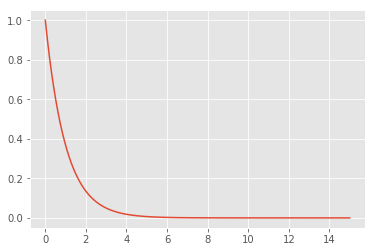

In [2]:
# Decide the prior parameters for U generation
a = 1.
b = 1.

x = np.linspace(0, 15, 1000)

prior_pdf = gamma.pdf(x, a, scale=1./b) 
plt.plot(x, prior_pdf)
plt.show()

In [7]:
N = 500 # number of observations
P = 2 # observation space dimensionality
K = 2 # latent space dimensionality
C = 2 # number of clusters

Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=0.5, eps=2., return_all=True)
log_Y = np.log(1 + Y)

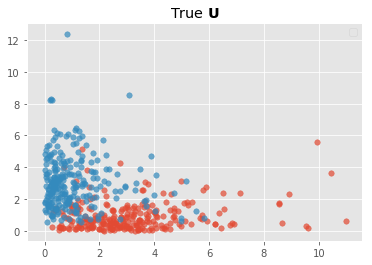

In [8]:
s = 30
alpha = 0.7
labels = []
handlers = []
for c in range(C):
    h = plt.scatter(U[0, int(c*N/C):int((c+1)*N/C)], U[1, int(c*N/C):int((c+1)*N/C)], s=s, alpha=alpha)
    handlers.append(h)
    
plt.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')
plt.show()

In [5]:
# ZIFA on the log pseudo-counts
zifa, model_params = ZIFA.fitModel(log_Y, K)

Running zero-inflated factor analysis with N = 500, D = 20, K = 2
Param change below threshold 1.000e-02 after 27 iterations


In [6]:
# PCA on the observations
pca = PCA(n_components=2).fit_transform(Y)

In [7]:
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5

cavi = inference.Inference(Y, alpha, beta, pi)

In [8]:
cavi.run_cavi(n_iterations=200, return_elbo=False)

Ran 200 iterations of CAVI.


In [9]:
# Use the means of the variational posterior approximations of U and V as their estimates
est_U = cavi.a[0] / cavi.a[1]
est_V = cavi.b[0] / cavi.b[1]

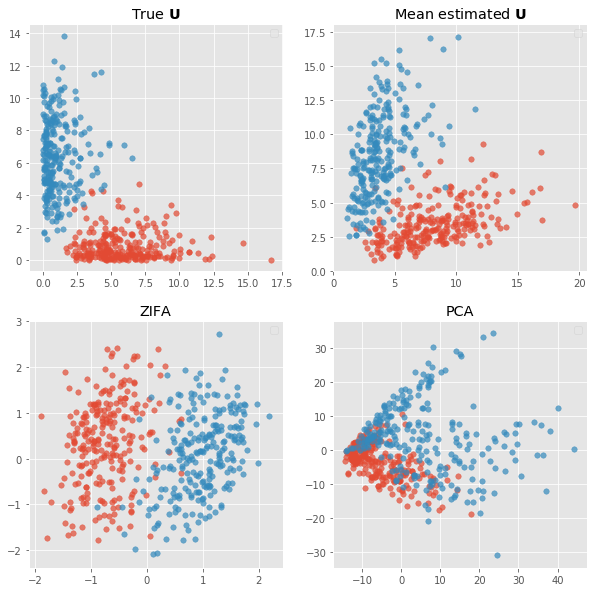

In [10]:
# Plot data
s = 30
alpha = 0.7

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(2, 2, 1)
handlers = []
for c in range(C):
    h = ax1.scatter(U[0, int(c*N/C):int((c+1)*N/C)], U[1, int(c*N/C):int((c+1)*N/C)], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')

ax2 = plt.subplot(2, 2, 2)
handlers = []
for c in range(C):
    h = ax2.scatter(est_U[int(c*N/C):int((c+1)*N/C), 0], est_U[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('Mean estimated $\mathbf{U}$')

ax3 = plt.subplot(2, 2, 3)
handlers = []
for c in range(C):
    h = ax3.scatter(zifa[int(c*N/C):int((c+1)*N/C), 0], zifa[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax3.legend(handlers, labels, scatterpoints=1)
plt.title('ZIFA')

ax4 = plt.subplot(2, 2, 4)
handlers = []
for c in range(C):
    h = ax4.scatter(pca[int(c*N/C):int((c+1)*N/C), 0], pca[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax4.legend(handlers, labels, scatterpoints=1)
plt.title('PCA')

plt.show()

In [11]:
pcmf_silh = silhouette_score(est_U, clusters)
pca_silh = silhouette_score(pca, clusters)
zifa_silh = silhouette_score(zifa, clusters)
scores = {'pCMF': pcmf_silh, 'ZIFA': zifa_silh, 'PCA': pca_silh}
max_key = max(scores, key=scores.get)

print('Silhouette scores (higher is better):')
for key in scores:
    if key == max_key: print('\033[1m', end="")
    print('- ' + key + ': %0.3f' % scores[key] + '\033[0m')

Silhouette scores (higher is better):
- ZIFA: 0.395
- pCMF: 0.446
- PCA: 0.212


In [12]:
alpha = np.ones((2, K))
# alpha[0, :] = 3.
# alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
cavi = inference.Inference(Y, alpha, beta, pi)

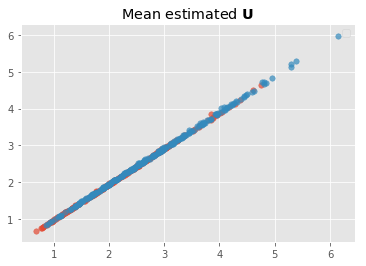

Silhouette: 0.04763879461905341

Mean V: 
[[1.67403744 1.72543617]
 [2.03124609 2.09565634]
 [1.71478574 1.76353793]
 [1.99262225 2.05550261]
 [0.76403684 0.78552104]
 [1.89813489 1.95380012]
 [1.56845211 1.6110044 ]
 [1.73306977 1.78676106]
 [1.48270656 1.52480903]
 [0.59006666 0.60782847]
 [1.30818104 1.34724053]
 [1.08338203 1.11850389]
 [3.16558182 3.26699459]
 [1.20002645 1.23122673]
 [0.63995924 0.65646283]
 [2.35102802 2.42502935]
 [2.30440828 2.37028529]
 [1.63796347 1.68056096]
 [1.10294969 1.13153778]
 [1.23282774 1.2685903 ]]
True V: 
[[0.74231923 0.85980661 1.76235156 0.3922003  0.54345897 0.85672351
  1.37712279 0.66363209 1.36765184 0.14357168 0.89839848 0.19117738
  1.57162844 1.3390795  0.6945157  0.47657365 2.31994921 2.0891934
  1.25276481 0.67446035]
 [1.54268631 1.95570407 0.67418605 2.2135477  0.4658073  1.83579879
  0.79996241 1.80232806 0.59662886 0.6231727  0.98157093 1.32151191
  2.86832273 0.34125218 0.14216927 2.64662706 1.00227514 0.10397087
  0.18221138 1.0

In [13]:
for _ in range(10):
    cavi.update_a()
    cavi.update_b()
    cavi.update_p()
    cavi.update_r()
    mean_U = cavi.a[0] / cavi.a[1]
    var_U = cavi.a[0] / (cavi.a[1] ** 2.)
    mean_V = cavi.b[0] / cavi.b[1]
handlers = []
for c in range(C):
    h = plt.scatter(mean_U[int(c*N/C):int((c+1)*N/C), 0], mean_U[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=0.7)
    handlers.append(h)
plt.legend(handlers, labels, scatterpoints=1)
plt.title('Mean estimated $\mathbf{U}$')
plt.show()

pcmf_silh = silhouette_score(mean_U, clusters)
print("Silhouette: " + str(pcmf_silh))
print("")

print('Mean V: \n' + str(mean_V))
print('True V: \n' + str(V))

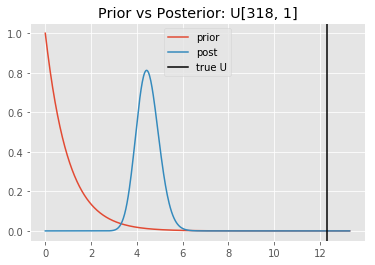

In [14]:
# Plot prior, estimated posterior and true value of some U[i, k]
i = np.random.randint(0, high=N)
k = np.random.randint(0, high=K)

x = np.linspace(0, U[k, i] + 1, 500)

prior_pdf = gamma.pdf(x, cavi.alpha[0, i, k], scale=1./cavi.alpha[1, i, k]) 
post_pdf = gamma.pdf(x, cavi.a[0, i, k], scale=1./cavi.a[1, i, k])
plt.plot(x, prior_pdf, label='prior')
plt.plot(x, post_pdf, label='post')
plt.axvline(x=U[k, i], label='true U', c='black')
plt.legend()
plt.title('Prior vs Posterior: U[%d, %d]' % (i, k))
plt.show()

In [15]:
cavi.b[1]

array([[633.83245044, 615.46220455],
       [592.28677031, 574.96059199],
       [633.18555763, 614.79961263],
       [586.32077298, 569.53670435],
       [582.78388033, 566.16133895],
       [626.81401243, 608.67150219],
       [634.14960617, 615.99255398],
       [682.75932496, 663.06036924],
       [607.36281565, 589.88316016],
       [608.90265862, 591.79004896],
       [576.23997495, 559.79149617],
       [592.93470559, 576.32807416],
       [648.66631401, 629.20021857],
       [578.51306346, 561.85348074],
       [599.31327772, 582.61323147],
       [631.49314236, 613.32945231],
       [643.75175155, 625.04422552],
       [552.97607989, 536.87155655],
       [600.39394568, 583.09647062],
       [644.09993185, 625.84093306]])

In [16]:
utils.sample_gamma(cavi.b[0], cavi.b[1]).shape

(20, 2)

In [17]:
V.shape

(2, 20)